In [373]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

import matplotlib.pyplot as plt

# ***************************************
#
# This function calculates and observes retention rates for 2019-2023
# and then forecasts retention rates for 2023-2035
# and then uses the 2019-2035 retention rates to estimate EXEPECTED/AVG RETENTION
#
# Input Data Set to this function:
# NAFCUSTOMER_REVENUE_AGGREGATED
# Each row represents one customer per year/month
# dimensions: customer name, setup date, BI_CUS_PAR, BI_PRODUCT, BI_MRU
# measures: revenue, spend, gallons, active cards and outstanding cards
#
# **************************************
#
# The data going into this step is defined in the follopwing Input View:
#
#  CREATE VIEW DATAIKU_ANALYTICS_SUB.DATA_SCIENCE.NAFCUSTOMER_REVENUE_AGGREGATED
#  AS
#  SELECT
#  CUSTOMER_ID,
#  CUSTOMER,
#  YEAR(REVENUE_DATE) as REVENUE_YEAR,
#  MONTH(REVENUE_DATE) as REVENUE_MONTH,
#  MIN(SETUP_DATE) AS SETUP_DATE,
#  MIN(BI_CUS_PAR) as BI_CUS_PAR,
#  MIN(BI_PRODUCT) as BI_PRODUCT,
#  MIN(BI_MRU) as BI_MRU,
#  SUM(REVENUE_AMOUNT_USD) as REVENUE_AMOUNT_USD,
#  SUM(GROSS_SPEND_AMOUNT) as GROSS_SPEND_AMOUNT,
#  SUM(PURCHASE_GALLONS_QTY) PURCHASE_GALLONS_QTY,
#  SUM(TOTAL_ACTIVE_CARD_COUNT) as TOTAL_ACTIVE_CARD_COUNT
#  FROM DATAIKU_ANALYTICS_SUB.DATA_SCIENCE.NAFCUSTOMER_REVENUE
#  WHERE (FUNDED_BY IS NULL OR FUNDED_BY='Unknown' OR FUNDED_BY='WEX Funded')
#  AND (NOT((REVENUE_CODE='26') AND (CUSTOMER_ID IS NULL)))
#  AND (NOT((REVENUE_CODE='E8') AND (CUSTOMER_ID IS NULL)))
#  GROUP BY 1,2,3,4
#
# ***************************************

from datetime import date, datetime, timedelta
import time

t0 = time.time()

# Read recipe inputs
NAFCUSTOMER_REVENUE_AGGREGATED = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED")
NAFCUSTOMER_REVENUE_AGGREGATED_df = NAFCUSTOMER_REVENUE_AGGREGATED.get_dataframe()

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df))
NAFCUSTOMER_REVENUE_AGGREGATED_df.head()



load duration 5.329603632291158 minutes
18075044


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT
0,77621209.0,VILLAGE OF DESHLER,2020,11,2017-10-16 07:00:00+00:00,11300.0,15100.0,4000.0,19.65,1513.02,704.699,8.0
1,77153661.0,CORPORATE SERVICES,2019,12,2018-10-25 07:00:00+00:00,21000.0,15110.0,4000.0,57.94,193.36,80.470,2.0
2,77374371.0,MAID IN J C,2019,3,2016-10-03 07:00:00+00:00,51200.0,15308.0,4120.0,3.40,256.62,90.098,1.0
3,77514713.0,SAFELITE GROUP INC,2019,10,2010-09-03 07:00:00+00:00,51000.0,10100.0,3100.0,22630.68,2311614.46,863540.642,6784.0
4,77522446.0,SCOTT EQUIPMENT PARENT,2020,7,2016-06-28 07:00:00+00:00,51000.0,10100.0,3100.0,2077.37,78830.18,37557.230,190.0


In [374]:
# create a copy of the input dataset
# this leaves the original dataset in memory and allows for a quick reload without having to back to Snowflake

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df), "rows in NAFCUSTOMER_REVENUE_AGGREGATED")
df = NAFCUSTOMER_REVENUE_AGGREGATED_df.copy()

18075044 rows in NAFCUSTOMER_REVENUE_AGGREGATED


In [375]:
# Prep data
#
# cast year to integer and create a revenue date column using month and year
#

df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype('Int64')
df['SETUP_DATE_DT'] = pd.to_datetime(df['SETUP_DATE'])

df['REVENUE_YEAR'] = df['REVENUE_YEAR'].astype('Int64')
df['REVENUE_DATE'] = df['REVENUE_MONTH'].astype(str) + '-' + df['REVENUE_YEAR'].astype(str)
df['REVENUE_DATE'] = pd.to_datetime(df['REVENUE_DATE'], format='%m-%Y').dt.strftime('%m-%Y')

#
# filter out Jan 2023 as it represents only a partial year
#
print(len(df), "before filter")
df = df[df.REVENUE_YEAR!=2023]
print(len(df), "after filter, removing 2023")

# break down of revenue_year
df.REVENUE_YEAR.value_counts(dropna=False)

18075044 before filter
17673397 after filter, removing 2023


2022    4836440
2021    4517640
2020    4243565
2019    4075752
NaN           0
Name: REVENUE_YEAR, dtype: Int64

In [387]:
import matplotlib.dates as mdates

# plot out sum of revenue per year
# in order to do a quick reonciliation against 

# aggregate revenue at annual grain
df_revenue_per_year = df.groupby(['REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
df_revenue_per_year.head()

max_revenue = df_revenue_per_year.REVENUE_AMOUNT_USD.max()

chart_revenue_year = [] 
for y in df_revenue_per_year.REVENUE_YEAR.tolist():
    chart_revenue_year.append(str(y))
    
fig, ax1 = plt.subplots(figsize=(16,5))
ax1.plot(chart_revenue_year,df_revenue_per_year['REVENUE_AMOUNT_USD'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('REVENUE', fontsize=14)
ax1.grid()
ax1.set_ylim(ymin=0)
fig.autofmt_xdate()
#ax1.xaxis.set_major_locator(mdates.YearLocator())
plt.show()

df_revenue_per_year.head()

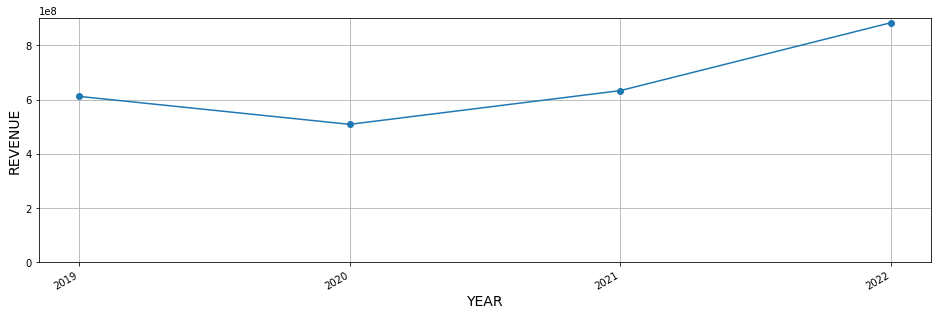

,REVENUE_YEAR,REVENUE_AMOUNT_USD
0,2019,6.118864e+08
1,2020,5.089365e+08
2,2021,6.331536e+08
3,2022,8.833003e+08


In [313]:
df_customer_monthly_card_count = df.groupby(['CUSTOMER_ID','REVENUE_DATE']).TOTAL_ACTIVE_CARD_COUNT.sum().reset_index()
df_customer_monthly_card_count.head()

,CUSTOMER_ID,REVENUE_DATE,TOTAL_ACTIVE_CARD_COUNT
0,77000000,01-2019,0.0
1,77000000,02-2019,0.0
2,77000000,03-2019,0.0
3,77000001,05-2022,1.0
4,77000001,06-2022,1.0


In [314]:
df_customer_max_monthly_card_sum = df.groupby(['CUSTOMER_ID']).TOTAL_ACTIVE_CARD_COUNT.max().reset_index()
df_customer_max_monthly_card_sum['CUSTOMER_FLEET_SIZE'] = 'NOT SET'
df_customer_max_monthly_card_sum.loc[df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>1700,'CUSTOMER_FLEET_SIZE'] = "XL (>1700 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>115)&(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=1700),'CUSTOMER_FLEET_SIZE'] = "L (>115 and <=1700 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]>21)&(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=115),'CUSTOMER_FLEET_SIZE'] = "M (>21 and <=115 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]<=21),'CUSTOMER_FLEET_SIZE'] = "S (<=21 Cards)"
df_customer_max_monthly_card_sum.loc[(df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"]==0),'CUSTOMER_FLEET_SIZE'] = "No Cards"
df_customer_max_monthly_card_sum.loc[df_customer_max_monthly_card_sum["TOTAL_ACTIVE_CARD_COUNT"].isnull(),'CUSTOMER_FLEET_SIZE'] = "No Cards"

df_customer_max_monthly_card_sum.CUSTOMER_FLEET_SIZE.value_counts(dropna=False)

S (<=21 Cards)               521977
No Cards                      80904
M (>21 and <=115 Cards)       40936
L (>115 and <=1700 Cards)      6735
XL (>1700 Cards)                334
Name: CUSTOMER_FLEET_SIZE, dtype: int64

In [316]:
# aggregate customers at min setup date
df_customer_min_setup = df.groupby(['CUSTOMER_ID']).SETUP_DATE.min().reset_index()
df_customer_min_setup.columns = ['CUSTOMER_ID','MIN_SETUP_DATE']
df_customer_min_setup['CUSTOMER_ID'] = df_customer_min_setup['CUSTOMER_ID'].astype('Int64')

df_customer_min_setup.head()

,CUSTOMER_ID,MIN_SETUP_DATE
0,77000000,2012-10-29 07:00:00+00:00
1,77000001,2022-04-12 07:00:00+00:00
2,77000002,2018-10-25 07:00:00+00:00
3,77000003,2022-06-08 07:00:00+00:00
4,77000004,2018-08-20 07:00:00+00:00


In [318]:
### print(len(df))
df_j = pd.merge(df, df_customer_min_setup, on='CUSTOMER_ID', how='inner')
print(len(df_j))

df_j = pd.merge(df_j, df_customer_max_monthly_card_sum, on='CUSTOMER_ID', how='inner')
print(len(df_j))

df_j.head()

17673363
17673363


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_MONTH,SETUP_DATE,BI_CUS_PAR,BI_PRODUCT,BI_MRU,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,PURCHASE_GALLONS_QTY,TOTAL_ACTIVE_CARD_COUNT_x,SETUP_DATE_DT,REVENUE_DATE,MIN_SETUP_DATE,TOTAL_ACTIVE_CARD_COUNT_y,CUSTOMER_FLEET_SIZE
0,77505014,ROLLINS INC,2021,9,2011-07-25 07:00:00+00:00,51000.0,10100.0,3100.0,83082.68,3281713.55,1025688.994,11111.0,2011-07-25 07:00:00+00:00,09-2021,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
1,77505014,ROLLINS INC,2019,2,2011-07-25 07:00:00+00:00,11200.0,10100.0,3100.0,52556.80,1983897.65,846550.421,9855.0,2011-07-25 07:00:00+00:00,02-2019,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
2,77505014,ROLLINS INC,2022,10,2011-07-25 07:00:00+00:00,20800.0,10100.0,3100.0,107859.83,4528629.56,1165272.708,13111.0,2011-07-25 07:00:00+00:00,10-2022,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
3,77505014,ROLLINS INC,2022,2,2011-07-25 07:00:00+00:00,51000.0,10100.0,3100.0,81521.57,3253294.57,919689.648,11284.0,2011-07-25 07:00:00+00:00,02-2022,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)
4,77505014,ROLLINS INC,2020,2,2011-07-25 07:00:00+00:00,11200.0,10100.0,3100.0,56223.23,2138943.47,862496.956,10371.0,2011-07-25 07:00:00+00:00,02-2020,2011-07-25 07:00:00+00:00,13189.0,XL (>1700 Cards)


In [319]:
print(len(df_j))
# retain only those customers that already existed before the analysis period
df_j = df_j[df_j.MIN_SETUP_DATE.dt.year<2019]
print(len(df_j))

17673363
13581403


Observed Average Retention Rate (2020-2022): 95.5 %


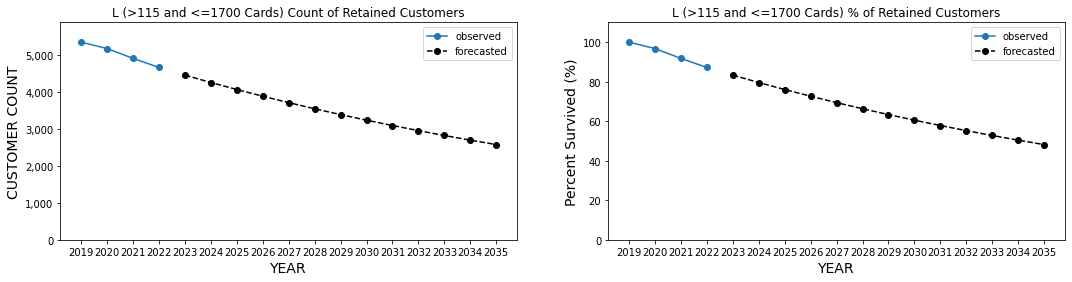

AVG Tenure (Observed + Forecasted): 11.63 Years
check_sum: 1.0


In [371]:
# Fleet Sizes
# S (<=21 Cards)
# No Cards
# M (>21 and <=115 Cards)
# L (>115 and <=1700 Cards)
# XL (>1700 Cards)

filtered_segment = 'L (>115 and <=1700 Cards)'

#print(len(df_j))
df_sub = df_j[df_j.CUSTOMER_FLEET_SIZE==filtered_segment]
#print(len(df_sub))

df_sub = df_sub.groupby(['REVENUE_YEAR']).CUSTOMER_ID.nunique().reset_index()
df_sub.columns = ['REVENUE_YEAR','CUSTOMER_COUNT']
df_sub.REVENUE_YEAR = df_sub.REVENUE_YEAR.astype(str)
df_sub.CUSTOMER_COUNT = df_sub.CUSTOMER_COUNT.astype('Int64')

df_sub['SURVIVED_FROM_FIRST'] = (df_sub.CUSTOMER_COUNT / df_sub.iloc[0].CUSTOMER_COUNT)
df_sub['SURVIVED_FROM_FIRST_PERCENT'] = (df_sub.CUSTOMER_COUNT / df_sub.iloc[0].CUSTOMER_COUNT)*100
df_sub['CUSTOMERS_LEFT'] = 0

row_count = len(df_sub)

row_index = 0
retention_observations = []
for i in range(row_count):
    if i>0:
        survived = df_sub.iloc[i].CUSTOMER_COUNT / df_sub.iloc[i-1].CUSTOMER_COUNT
        df_sub.loc[i,'SURVIVED_FROM_PREV'] = survived
        df_sub.loc[i,'CUSTOMERS_LEFT'] = df_sub.iloc[i-1].CUSTOMER_COUNT - df_sub.iloc[i].CUSTOMER_COUNT
        retention_observations.append(survived)
    row_index+=1
        
avg_retention_rate = sum(retention_observations)/len(retention_observations)                
print("Observed Average Retention Rate (2020-2022):", 100*round(avg_retention_rate,3), "%")

forecast_year = 2022

df_sub['FORECAST_CUSTOMER_COUNT'] = np.nan
df_sub['FORECAST_FROM_FIRST_PERCENT'] = np.nan
for i in range(13):

    forecast_year += 1
    if i==0:
        forecast_customer_count = round(avg_retention_rate * df_sub.iloc[i+row_count-1].CUSTOMER_COUNT,0)
        customers_left = df_sub.iloc[i+row_count-1].CUSTOMER_COUNT - forecast_customer_count
    else:
        forecast_customer_count = round(avg_retention_rate * df_sub.iloc[i+row_count-1].FORECAST_CUSTOMER_COUNT,0)
        customers_left = df_sub.iloc[i+row_count-1].FORECAST_CUSTOMER_COUNT - forecast_customer_count
    
    forecast_from_first_percent = (forecast_customer_count/df_sub.iloc[0].CUSTOMER_COUNT)*100
        
    dict = {'REVENUE_YEAR':forecast_year,'CUSTOMERS_LEFT': customers_left, 'SURVIVED_FROM_PREV': avg_retention_rate, 'FORECAST_CUSTOMER_COUNT':forecast_customer_count,'FORECAST_FROM_FIRST_PERCENT':forecast_from_first_percent}
    df_sub = df_sub.append(dict, ignore_index = True)

    
df_sub['CUSTOMERS_LEFT_PERCENT'] = df_sub['CUSTOMERS_LEFT'] / df_sub.iloc[0].CUSTOMER_COUNT
df_sub.FORECAST_CUSTOMER_COUNT = df_sub.FORECAST_CUSTOMER_COUNT.astype('Int64') 

chart_revenue_year = df_sub.REVENUE_YEAR[0:row_index].tolist()
chart_customer_count = df_sub.CUSTOMER_COUNT[0:row_index].tolist()

chart_survived_from_first = df_sub.SURVIVED_FROM_FIRST_PERCENT[0:row_index].tolist()

l = []
for i in df_sub.REVENUE_YEAR[row_index:].tolist():
    l.append(str(int(i)))

chart_forecast_year = l
chart_forecast_customer_count = df_sub.FORECAST_CUSTOMER_COUNT[row_index:].tolist()
chart_forecast_from_first = df_sub.FORECAST_FROM_FIRST_PERCENT[row_index:].tolist()

max_y = df_sub.CUSTOMER_COUNT.max()
max_y = max_y + max_y*0.1

fig = plt.figure(figsize=(18,4))
ax1 = fig.add_subplot(1,2,1); 
plt.plot(chart_revenue_year,chart_customer_count, marker='o', c='C0')
plt.plot(chart_forecast_year,chart_forecast_customer_count, marker='o', c='black', linestyle='dashed')
ax1.set_ylim(ymin=0, ymax=max_y)
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('CUSTOMER COUNT', fontsize=14)
#ax1.grid()
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title(filtered_segment + ' Count of Retained Customers')
plt.legend(['observed','forecasted'])

ax2 = fig.add_subplot(1,2,2); 
plt.plot(chart_revenue_year,chart_survived_from_first, marker='o', c='C0')
plt.plot(chart_forecast_year,chart_forecast_from_first, marker='o', c='black', linestyle='dashed')
ax2.set_ylim(ymin=0, ymax=110)
ax2.set_xlabel('YEAR', fontsize=14)
ax2.set_ylabel('Percent Survived (%)', fontsize=14)
#ax2.grid()
plt.title(filtered_segment + ' % of Retained Customers')
plt.legend(['observed','forecasted'])

plt.show()

fraction_remaining = 1
avg_tenure = 0
check_sum = 0
for i in range(len(df_sub)):
    avg_tenure += df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT * i
    fraction_remaining -=  df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT
    check_sum += df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT
    #print("YEAR", i, df_sub.iloc[i].CUSTOMERS_LEFT, df_sub.iloc[i].CUSTOMERS_LEFT_PERCENT)

check_sum += fraction_remaining
avg_tenure += fraction_remaining * i
print("AVG Tenure (Observed + Forecasted):", round(avg_tenure,2), "Years")
print("check_sum:", round(check_sum,2))

In [368]:
df_sub.head(5)

,REVENUE_YEAR,CUSTOMER_COUNT,SURVIVED_FROM_FIRST,SURVIVED_FROM_FIRST_PERCENT,CUSTOMERS_LEFT,SURVIVED_FROM_PREV,FORECAST_CUSTOMER_COUNT,FORECAST_FROM_FIRST_PERCENT,CUSTOMERS_LEFT_PERCENT
0,2019,303133,1.000000,100.000000,0.0,NaN,<NA>,NaN,0.000000
1,2020,270617,0.892734,89.273355,32516.0,0.892734,<NA>,NaN,0.107266
2,2021,242653,0.800484,80.048362,27964.0,0.896666,<NA>,NaN,0.092250
3,2022,223282,0.736581,73.658097,19371.0,0.920170,<NA>,NaN,0.063903
4,2023,NaN,NaN,NaN,21616.0,0.903190,201666,66.527234,0.071309


In [0]:
# Compute recipe outputs from inputs
# TODO: Replace this part by your actual code that computes the output, as a Pandas dataframe
# NB: DSS also supports other kinds of APIs for reading and writing data. Please see doc.

#TENURE_CALC_df = NAFCUSTOMER_REVENUE_AGGREGATED_df # For this sample code, simply copy input to output


# Write recipe outputs
#TENURE_CALC = dataiku.Dataset("TENURE_CALC")
#TENURE_CALC.write_with_schema(TENURE_CALC_df)